## Case Study 2: Risk Averse SVM for dogs vs cats classification

In [22]:
import argparse
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

"""
SVM with perturbed images of cats and dogs
lables: -1 -> cats, 1 -> dogs

"""
## Solver options for the optimization problem
solver_opts = {"eps_abs": 1e-5, "eps_rel": 1e-5, "max_iter": 10000}

def svm_loss_func(x, y, w, b):
    return max(0.0, 1.0 - y * (np.dot(w, x) - b))


def load_images(dimension=64, load_in_gray=True, max_per_class=None):
    # For notebooks, use the train directory relative to current working directory
    path = "train"
    images = []
    labels = []
    class_counts = {'cat': 0, 'dog': 0}

    for filename in tqdm(sorted(os.listdir(path)), desc="Loading images"):
        if filename.endswith('.jpg'):
            # Check if we've reached the limit for this class
            if max_per_class is not None:
                class_type = 'cat' if 'cat' in filename else 'dog'
                if class_counts[class_type] >= max_per_class:
                    continue

            img_path = os.path.join(path, filename)
            img = Image.open(img_path)
            img_array = np.array(img)
            img_array = preprocess_image_loading(img_array, target_size=(dimension, dimension), to_gray=load_in_gray)
            images.append(img_array)
            label = -1 if 'cat' in filename else 1
            labels.append(label)

            # Update class count
            if max_per_class is not None:
                class_counts[class_type] += 1

    df = pd.DataFrame({'image': images, 'label': labels})
    return df

# Resize the images to 64 x 64 and flatten
def preprocess_image_loading(img, target_size=(64,64), to_gray=True):
    img = Image.fromarray(img)
    if to_gray:
        img = img.convert('L')  # Convert to grayscale
    img = img.resize(target_size)
    img_array = np.array(img).flatten() / 255.0  # Normalize pixel values
    return img_array


def solve_svm_nominal(x, y, lambda_reg):
    n, d = x.shape
    w = cp.Variable(d)
    b = cp.Variable()
    zeta = cp.Variable(n)
    ## Define the constraints
    constraints = []
    constraints += [zeta >= 0, cp.multiply(y, x @ w - b) >= 1 - zeta]
    
    ## Define the objective
    objective = cp.Minimize(lambda_reg * cp.sum_squares(w) + (1.0 / n) * cp.sum(zeta))
    
    ## Define the problem
    prob = cp.Problem(objective, constraints)
    
    prob.solve(solver=cp.OSQP, **solver_opts)
    
    w_val = w.value
    b_val = b.value
    zeta_val = zeta.value
    obj_val = prob.value
    print("Solver status (nominal):", prob.status)
    return w_val, b_val, zeta_val, obj_val

def solve_svm_cvar(x, y, lambda_reg, alpha, N):
    _ , n, d = x.shape
    w = cp.Variable(d)
    b = cp.Variable()
    zeta = cp.Variable((n,N))
    u = cp.Variable(N)
    t = cp.Variable()
    
    ## Define the objective
    obj = t + (1.0 / ((1.0 - alpha) * float(N))) * cp.sum(u) + lambda_reg * cp.sum_squares(w)
    objective = cp.Minimize(obj)
    
    ## Define the constraints
    
    constraints = []
    
    ## Constraints for each pertubed scenario
    ## For scenario k: zeta[:,k] >= 1 - y * (Xk @ w - b); zeta[:,k] >= 0

    for k in range(N):
        x_k = x[k,:,:]
        constraints += [zeta[:, k] >= 0]
        constraints += [cp.multiply(y, x_k @ w - b) >= 1 - zeta[:, k]]
    
    ## Constraints for u
    for k in range(N):
        constraints += [u[k] >= 0]
        constraints += [u[k] >= ((1.0/n) * cp.sum(zeta[:, k]) - t)]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.OSQP, **solver_opts)
    
    print("Solver status (CVaR):", problem.status)
    
    return w.value, b.value, problem.value, t.value

def calc_metrics(x, y, w, b):
    scores = x @ w - b
    y_pred = np.where(scores >= 0, 1, -1)
    accuracy = accuracy_score(y, y_pred)
    confusion_mat = confusion_matrix(y, y_pred)
    return accuracy, confusion_mat

def evaluate_losses(x, y, w, b,  M):
    """Evaluate hinge losses for test samples."""
    losses = []
    for k in range(M):
        loss = np.array([svm_loss_func(x[k,i], y[i], w, b) for i in range(x.shape[1])])
        losses.append(loss.mean())
        
    return np.array(losses)

def cvar_empirical(values, alpha):
    """
    Empirical CVaR_alpha for a 1D array of loss values:
      CVaR = mean of the upper (1-alpha) tail (>= VaR_alpha).
    """
    values = np.asarray(values, dtype=float)
    if not (0.0 < alpha < 1.0):
        raise ValueError("alpha must be in (0,1)")
    if values.size == 0:
        return np.nan
    # Empirical VaR at level alpha
    var_alpha = np.quantile(values, alpha)
    tail = values[values >= var_alpha]
    return float(tail.mean())


def calc_metrics_noisy(x_noisy, y, w, b, M):
    """Calculate average accuracy and confusion matrix across M noisy scenarios."""
    accuracies = []
    confusion_mats = []

    for k in range(M):
        x_k = x_noisy[k, :, :]
        scores = x_k @ w - b
        y_pred = np.where(scores >= 0, 1, -1)
        acc = accuracy_score(y, y_pred)
        conf_mat = confusion_matrix(y, y_pred)
        accuracies.append(acc)
        confusion_mats.append(conf_mat)

    avg_accuracy = np.mean(accuracies)
    avg_confusion_mat = np.mean(confusion_mats, axis=0)

    return avg_accuracy, avg_confusion_mat


def cvar_accuracy(x_noisy, y, w, b, alpha, M):
    """Calculate CVaR of accuracy (worst-case average accuracy for bottom (1-alpha) tail)."""
    accuracies = []

    for k in range(M):
        x_k = x_noisy[k, :, :]
        scores = x_k @ w - b
        y_pred = np.where(scores >= 0, 1, -1)
        acc = accuracy_score(y, y_pred)
        accuracies.append(acc)

    accuracies = np.array(accuracies)
    # For accuracy, lower is worse, so we want the lower (1-alpha) tail
    var_alpha = np.quantile(accuracies, 1 - alpha)
    tail = accuracies[accuracies <= var_alpha]
    return float(tail.mean())


In [23]:
## Configurations
seed = 340
dimension = 64      
lambda_reg = 1e-3
alpha = 0.95
grayscale = True
max_per_class = 100  # Increased from 100 to get more training data
N = 10 # Number of perturbed training scenarios for CVaR optimization 
M = 100 # Number of perturbed test scenarios for evaluation
sigma = 0.8 #Standard deviation of noise for perturbed scenarios

In [24]:
## ============================================================================
## DATA LOADING AND PREPROCESSING
## ============================================================================

## Load the images and preprocess
df = load_images(dimension=dimension, load_in_gray=grayscale, max_per_class=max_per_class)
x = np.array(df['image'].tolist())  # Convert DataFrame column to 2D array
y = df['label'].values
np.random.seed(seed)

## Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=seed)

## Standardize features (zero mean, unit variance)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Loading images:   0%|          | 0/25000 [00:00<?, ?it/s]

Loading images: 100%|██████████| 25000/25000 [00:00<00:00, 57541.60it/s]


### Standard Normal Distribution Pertubation

In [25]:
## ============================================================================
## NORMAL DISTRIBUTION PERTURBATIONS
## ============================================================================

## Generate N perturbed training scenarios and M perturbed test scenarios
rng = np.random.default_rng(seed)
x_train_noisy = np.zeros((N, x_train.shape[0], x_train.shape[1]))
for k in range(N):
    x_train_noisy[k, :, :] = x_train + rng.normal(0, sigma, size=x_train.shape)
rng = np.random.default_rng(seed + 1)
x_test_noisy = np.zeros((M, x_test.shape[0], x_test.shape[1]))
for k in range(M):
    x_test_noisy[k, :, :] = x_test + rng.normal(0, sigma, size=x_test.shape)

## ============================================================================
## NOMINAL SVM OPTIMIZATION
## ============================================================================

## Solve standard (nominal) SVM on clean training data
w_nom, b_nom, zeta_nom, obj_nom = solve_svm_nominal(
    x_train, y_train, lambda_reg=lambda_reg
)

## Evaluate nominal solution on M perturbed test scenarios
losses_nom = evaluate_losses(x_test_noisy, y_test, w_nom, b_nom, M=M)
cvar_nom = cvar_empirical(losses_nom, alpha)
mean_nom = float(losses_nom.mean())

## Calculate metrics on clean and perturbed test data
test_acc_nom, test_conf_mat_nom = calc_metrics(x_test, y_test, w_nom, b_nom)
avg_acc_nom, avg_conf_nom = calc_metrics_noisy(
    x_test_noisy, y_test, w_nom, b_nom, M=M
)
cvar_acc_nom = cvar_accuracy(x_test_noisy, y_test, w_nom, b_nom, alpha, M=M)

## Print nominal SVM results
print("Nominal SVM Results:")
print("  Value of objective at optimum = ", obj_nom)
print(f"Test Set Results (test_N = {x_test.shape[0]}):")
print(f"  Mean hinge loss (perturbed, M={M}) = {mean_nom:.6f}")
print(f"  CVaR@{alpha} hinge loss (perturbed) = {cvar_nom:.6f}")
print(f"  Mean accuracy (perturbed, M={M}) = {avg_acc_nom*100:.2f}%")
print(f"  CVaR@{alpha} accuracy (perturbed) = {cvar_acc_nom*100:.2f}%")
print("  Average Test Confusion Matrix (perturbed):")
print(avg_conf_nom)

print(f"\nTest Accuracy (unperturbed): {test_acc_nom*100:.2f}%")
print("Test Confusion Matrix (unperturbed):")
print(test_conf_mat_nom)


## ============================================================================
## CVaR-OPTIMIZED SVM
## ============================================================================

## Solve CVaR-optimized SVM using N perturbed training scenarios
w_cvar, b_cvar, obj_cvar, var_cvar = solve_svm_cvar(
    x_train_noisy,
    y_train,
    lambda_reg=lambda_reg,
    alpha=alpha,
    N=N,
)

## Evaluate CVaR solution on M perturbed test scenarios
losses_cvar = evaluate_losses(x_test_noisy, y_test, w_cvar, b_cvar, M=M)
cvar_cvar = cvar_empirical(losses_cvar, alpha)
mean_cvar = float(losses_cvar.mean())

## Calculate metrics on clean and perturbed test data
test_acc_cvar, test_conf_mat_cvar = calc_metrics(x_test, y_test, w_cvar, b_cvar)
avg_acc_cvar, avg_conf_cvar = calc_metrics_noisy(
    x_test_noisy, y_test, w_cvar, b_cvar, M=M
)
cvar_acc_cvar = cvar_accuracy(x_test_noisy, y_test, w_cvar, b_cvar, alpha, M=M)

## Print CVaR-optimized SVM results
print("CVaR-optimized SVM Results:")
print("  Value of objective at optimum = ", obj_cvar)
print(f"Test Set Results (test_N = {x_test.shape[0]}):")
print(f"  Mean hinge loss (perturbed, M={M}) = {mean_cvar:.6f}")
print(f"  CVaR@{alpha} hinge loss (perturbed) = {cvar_cvar:.6f}")
print(f"  Mean accuracy (perturbed, M={M}) = {avg_acc_cvar*100:.2f}%")
print(f"  CVaR@{alpha} accuracy (perturbed) = {cvar_acc_cvar*100:.2f}%")
print("  Average Test Confusion Matrix (perturbed):")
print(avg_conf_cvar)
print(f"\nTest Accuracy (unperturbed): {test_acc_cvar*100:.2f}%")
print("Test Confusion Matrix (unperturbed):")
print(test_conf_mat_cvar)


## ============================================================================
## COMPARISON: NOMINAL vs CVaR
## ============================================================================

print("\n" + "="*60)
print("Comparison (Test Set): CVaR@alpha=%.2f" % alpha)
print("="*60)
print("\nHinge Loss (Perturbed):")
print(
    "  CVaR(cvar)  vs  CVaR(nominal)  -->  %.6f  vs  %.6f"
    % (cvar_cvar, cvar_nom)
)
print(
    "  Mean(cvar)  vs  Mean(nominal)  -->  %.6f  vs  %.6f"
    % (mean_cvar, mean_nom)
)
print("\nAccuracy (Perturbed):")
print(
    "  CVaR(cvar)  vs  CVaR(nominal)  -->  %.2f%%  vs  %.2f%%"
    % (cvar_acc_cvar*100, cvar_acc_nom*100)
)
print(
    "  Mean(cvar)  vs  Mean(nominal)  -->  %.2f%%  vs  %.2f%%"
    % (avg_acc_cvar*100, avg_acc_nom*100)
)

Solver status (nominal): optimal
Nominal SVM Results:
  Value of objective at optimum =  0.00014174545180474363
Test Set Results (test_N = 100):
  Mean hinge loss (perturbed, M=100) = 1.048188
  CVaR@0.95 hinge loss (perturbed) = 1.114922
  Mean accuracy (perturbed, M=100) = 51.89%
  CVaR@0.95 accuracy (perturbed) = 47.29%
  Average Test Confusion Matrix (perturbed):
[[28.05 20.95]
 [27.16 23.84]]

Test Accuracy (unperturbed): 53.00%
Test Confusion Matrix (unperturbed):
[[28 21]
 [26 25]]
Solver status (CVaR): optimal
CVaR-optimized SVM Results:
  Value of objective at optimum =  0.00011163173636130909
Test Set Results (test_N = 100):
  Mean hinge loss (perturbed, M=100) = 0.978372
  CVaR@0.95 hinge loss (perturbed) = 1.029240
  Mean accuracy (perturbed, M=100) = 54.53%
  CVaR@0.95 accuracy (perturbed) = 49.29%
  Average Test Confusion Matrix (perturbed):
[[29.21 19.79]
 [25.68 25.32]]

Test Accuracy (unperturbed): 58.00%
Test Confusion Matrix (unperturbed):
[[31 18]
 [24 27]]

Compari

Total examples where CVaR predicted correctly but Nominal didn't: 776
Cat examples (label=-1): 380
Dog examples (label=1): 396

Selected 1 cat examples and 1 dog examples
Total selected: 2


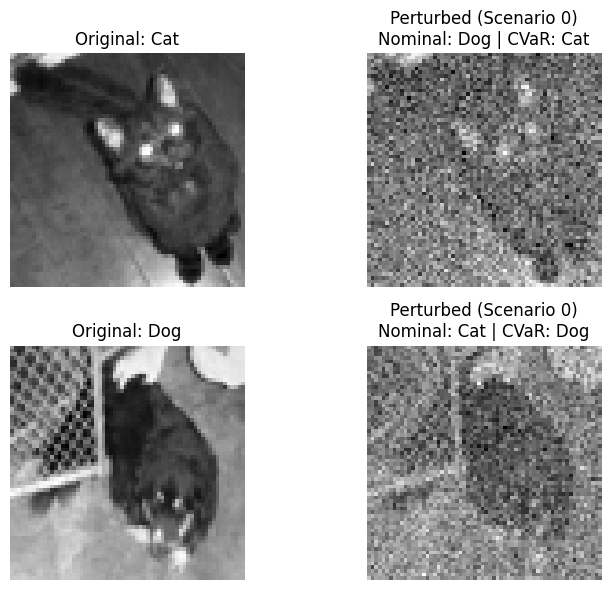


SUMMARY OF SELECTED EXAMPLES
1. Scenario 0, Test Image 32
   True: Cat, Nominal predicted: Dog, CVaR predicted: Cat
2. Scenario 0, Test Image 31
   True: Dog, Nominal predicted: Cat, CVaR predicted: Dog


In [26]:
## ============================================================================
## FIND EXAMPLES WHERE CVaR WINS: Correct predictions where Nominal fails
## ============================================================================

## Get predictions for all M perturbed scenarios
cvar_wins_examples = []

for scenario_idx in range(M):
    x_perturbed = x_test_noisy[scenario_idx, :, :]
    
    # Get predictions for both models
    scores_nom = x_perturbed @ w_nom - b_nom
    y_pred_nom = np.where(scores_nom >= 0, 1, -1)
    
    scores_cvar = x_perturbed @ w_cvar - b_cvar
    y_pred_cvar = np.where(scores_cvar >= 0, 1, -1)
    
    # Find cases where CVaR is correct but nominal is wrong
    cvar_correct = (y_pred_cvar == y_test)
    nom_wrong = (y_pred_nom != y_test)
    cvar_wins_mask = cvar_correct & nom_wrong
    
    # Get indices where CVaR wins
    win_indices = np.where(cvar_wins_mask)[0]
    
    for idx in win_indices:
        cvar_wins_examples.append({
            'scenario': scenario_idx,
            'test_idx': idx,
            'true_label': y_test[idx],
            'nom_pred': y_pred_nom[idx],
            'cvar_pred': y_pred_cvar[idx],
            'perturbed_image': x_perturbed[idx],
            'original_image': x_test[idx]
        })

print(f"Total examples where CVaR predicted correctly but Nominal didn't: {len(cvar_wins_examples)}")

## Select 1 from each class
cats_examples = [ex for ex in cvar_wins_examples if ex['true_label'] == -1]
dogs_examples = [ex for ex in cvar_wins_examples if ex['true_label'] == 1]

print(f"Cat examples (label=-1): {len(cats_examples)}")
print(f"Dog examples (label=1): {len(dogs_examples)}")

# Select up to 1 from each class
selected_cats = cats_examples[:1]
selected_dogs = dogs_examples[:1]
selected_examples = selected_cats + selected_dogs

print(f"\nSelected {len(selected_cats)} cat examples and {len(selected_dogs)} dog examples")
print(f"Total selected: {len(selected_examples)}")

## Display the selected examples
if len(selected_examples) > 0:
    fig, axes = plt.subplots(len(selected_examples), 2, figsize=(8, 3*len(selected_examples)))
    if len(selected_examples) == 1:
        axes = axes.reshape(1, -1)
    
    for i, example in enumerate(selected_examples):
        true_class = "Cat" if example['true_label'] == -1 else "Dog"
        nom_class = "Cat" if example['nom_pred'] == -1 else "Dog"
        cvar_class = "Cat" if example['cvar_pred'] == -1 else "Dog"
        
        # Original image
        orig_img = example['original_image'].reshape(dimension, dimension)
        axes[i, 0].imshow(orig_img, cmap='gray')
        axes[i, 0].set_title(f"Original: {true_class}")
        axes[i, 0].axis('off')
        
        # Perturbed image
        pert_img = example['perturbed_image'].reshape(dimension, dimension)
        axes[i, 1].imshow(pert_img, cmap='gray')
        axes[i, 1].set_title(f"Perturbed (Scenario {example['scenario']})\nNominal: {nom_class} | CVaR: {cvar_class}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("SUMMARY OF SELECTED EXAMPLES")
    print("="*60)
    for i, ex in enumerate(selected_examples):
        true_class = "Cat" if ex['true_label'] == -1 else "Dog"
        nom_class = "Cat" if ex['nom_pred'] == -1 else "Dog"
        cvar_class = "Cat" if ex['cvar_pred'] == -1 else "Dog"
        print(f"{i+1}. Scenario {ex['scenario']}, Test Image {ex['test_idx']}")
        print(f"   True: {true_class}, Nominal predicted: {nom_class}, CVaR predicted: {cvar_class}")
else:
    print("\nNo examples found where CVaR wins over Nominal!")


### Students-t distributed pertubation

In [30]:
## ============================================================================
## STUDENT'S T-DISTRIBUTION PERTURBATIONS (df=2, heavy-tailed)
## ============================================================================

## Generate N perturbed training scenarios and M perturbed test scenarios with heavy-tailed noise
rng = np.random.default_rng(seed)
x_train_noisy = np.zeros((N, x_train.shape[0], x_train.shape[1]))
for k in range(N):
    x_train_noisy[k, :, :] = x_train + rng.standard_t(df=3, size=x_train.shape) * sigma
rng = np.random.default_rng(seed + 1)
x_test_noisy = np.zeros((M, x_test.shape[0], x_test.shape[1]))
for k in range(M):
    x_test_noisy[k, :, :] = x_test + rng.standard_t(df=3, size=x_test.shape) * sigma

## ============================================================================
## NOMINAL SVM OPTIMIZATION
## ============================================================================

## Solve standard (nominal) SVM on clean training data
w_nom, b_nom, zeta_nom, obj_nom = solve_svm_nominal(
    x_train, y_train, lambda_reg=lambda_reg
)

## Evaluate nominal solution on M perturbed test scenarios
losses_nom = evaluate_losses(x_test_noisy, y_test, w_nom, b_nom, M=M)
cvar_nom = cvar_empirical(losses_nom, alpha)
mean_nom = float(losses_nom.mean())

## Calculate metrics on clean and perturbed test data
test_acc_nom, test_conf_mat_nom = calc_metrics(x_test, y_test, w_nom, b_nom)
avg_acc_nom, avg_conf_nom = calc_metrics_noisy(
    x_test_noisy, y_test, w_nom, b_nom, M=M
)
cvar_acc_nom = cvar_accuracy(x_test_noisy, y_test, w_nom, b_nom, alpha, M=M)

## Print nominal SVM results
print("Nominal SVM Results:")
print("  Value of objective at optimum = ", obj_nom)
print(f"Test Set Results (test_N = {x_test.shape[0]}):")
print(f"  Mean hinge loss (perturbed, M={M}) = {mean_nom:.6f}")
print(f"  CVaR@{alpha} hinge loss (perturbed) = {cvar_nom:.6f}")
print(f"  Mean accuracy (perturbed, M={M}) = {avg_acc_nom*100:.2f}%")
print(f"  CVaR@{alpha} accuracy (perturbed) = {cvar_acc_nom*100:.2f}%")
print("  Average Test Confusion Matrix (perturbed):")
print(avg_conf_nom)

print(f"\nTest Accuracy (unperturbed): {test_acc_nom*100:.2f}%")
print("Test Confusion Matrix (unperturbed):")
print(test_conf_mat_nom)

## ============================================================================
## CVaR-OPTIMIZED SVM
## ============================================================================

## Solve CVaR-optimized SVM using N perturbed training scenarios
w_cvar, b_cvar, obj_cvar, var_cvar = solve_svm_cvar(
    x_train_noisy,
    y_train,
    lambda_reg=lambda_reg,
    alpha=alpha,
    N=N,
)

## Evaluate CVaR solution on M perturbed test scenarios
losses_cvar = evaluate_losses(x_test_noisy, y_test, w_cvar, b_cvar, M=M)
cvar_cvar = cvar_empirical(losses_cvar, alpha)
mean_cvar = float(losses_cvar.mean())

## Calculate metrics on clean and perturbed test data
test_acc_cvar, test_conf_mat_cvar = calc_metrics(x_test, y_test, w_cvar, b_cvar)
avg_acc_cvar, avg_conf_cvar = calc_metrics_noisy(
    x_test_noisy, y_test, w_cvar, b_cvar, M=M
)
cvar_acc_cvar = cvar_accuracy(
    x_test_noisy, y_test, w_cvar, b_cvar, alpha, M=M
)

## Print CVaR-optimized SVM results
print(f"\n\nCVaR-optimized SVM Results:")
print("  Value of objective at optimum = ", obj_cvar)
print(f"Test Set Results (test_N = {x_test.shape[0]}):")
print(f"  Mean hinge loss (perturbed, M={M}) = {mean_cvar:.6f}")
print(f"  CVaR@{alpha} hinge loss (perturbed) = {cvar_cvar:.6f}")
print(f"  Mean accuracy (perturbed, M={M}) = {avg_acc_cvar*100:.2f}%")
print(f"  CVaR@{alpha} accuracy (perturbed) = {cvar_acc_cvar*100:.2f}%")
print("  Average Test Confusion Matrix (perturbed):")
print(avg_conf_cvar)
print(f"\nTest Accuracy (unperturbed): {test_acc_cvar*100:.2f}%")
print("Test Confusion Matrix (unperturbed):")
print(test_conf_mat_cvar)

## ============================================================================
## COMPARISON: NOMINAL vs CVaR
## ============================================================================

print("\n" + "=" * 60)
print("Comparison (Test Set): CVaR@alpha=%.2f" % alpha)
print("=" * 60)
print("\nHinge Loss (Perturbed):")
print("  CVaR(cvar)  vs  CVaR(nominal)  -->  %.6f  vs  %.6f" % (cvar_cvar, cvar_nom))
print("  Mean(cvar)  vs  Mean(nominal)  -->  %.6f  vs  %.6f" % (mean_cvar, mean_nom))
print("\nAccuracy (Perturbed):")
print(
    "  CVaR(cvar)  vs  CVaR(nominal)  -->  %.2f%%  vs  %.2f%%"
    % (cvar_acc_cvar * 100, cvar_acc_nom * 100)
)
print(
    "  Mean(cvar)  vs  Mean(nominal)  -->  %.2f%%  vs  %.2f%%"
    % (avg_acc_cvar * 100, avg_acc_nom * 100)
)

Solver status (nominal): optimal
Nominal SVM Results:
  Value of objective at optimum =  0.00014174545180474363
Test Set Results (test_N = 100):
  Mean hinge loss (perturbed, M=100) = 1.064035
  CVaR@0.95 hinge loss (perturbed) = 1.159555
  Mean accuracy (perturbed, M=100) = 51.49%
  CVaR@0.95 accuracy (perturbed) = 45.71%
  Average Test Confusion Matrix (perturbed):
[[27.58 21.42]
 [27.09 23.91]]

Test Accuracy (unperturbed): 53.00%
Test Confusion Matrix (unperturbed):
[[28 21]
 [26 25]]
Solver status (CVaR): optimal


CVaR-optimized SVM Results:
  Value of objective at optimum =  6.992438587473553e-05
Test Set Results (test_N = 100):
  Mean hinge loss (perturbed, M=100) = 0.958132
  CVaR@0.95 hinge loss (perturbed) = 1.032895
  Mean accuracy (perturbed, M=100) = 54.86%
  CVaR@0.95 accuracy (perturbed) = 48.22%
  Average Test Confusion Matrix (perturbed):
[[29.11 19.89]
 [25.25 25.75]]

Test Accuracy (unperturbed): 57.00%
Test Confusion Matrix (unperturbed):
[[32 17]
 [26 25]]

Compar